In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
file_path = 'dataset/data.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to confirm it's loaded correctly
print(data.head())

data.info()


                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    str

In [18]:
data.isnull().sum()


date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

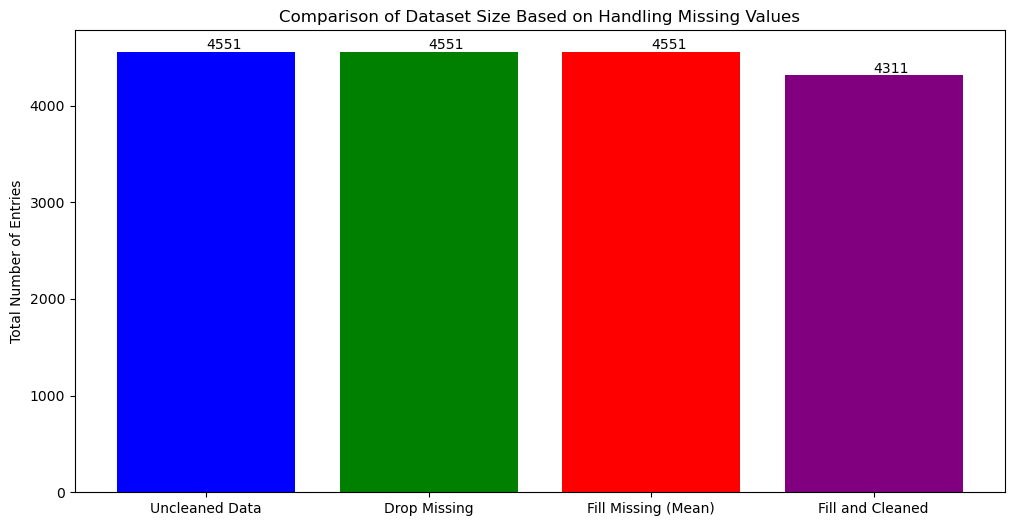

In [19]:
# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'])

#remove where price is 0
data = data[data['price'] != 0]

# Initial total count
initial_count = len(data)

# Handle missing values by dropping them
data_dropna = data.dropna()
dropna_count = len(data_dropna)

# Handle missing values by filling them with the mean for numerical columns
data_fillmean = data.copy()
for column in ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
               'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']:
    data_fillmean[column] = data_fillmean[column].fillna(data_fillmean[column].mean())
fillmean_count = len(data_fillmean)

# Feature Engineering
data_fillmean['house_age'] = 2023 - data_fillmean['yr_built']  # Assuming current year is 2023
data_fillmean['years_since_renovation'] = data_fillmean.apply(
    lambda row: 2023 - row['yr_renovated'] if row['yr_renovated'] > 0 else 0, axis=1)
data_fillmean['total_sqft'] = data_fillmean['sqft_living'] + data_fillmean['sqft_lot']
data_fillmean['price_per_sqft'] = data_fillmean['price'] / data_fillmean['sqft_living']
data_fillmean['bed_to_bath_ratio'] = data_fillmean['bedrooms'] / data_fillmean['bathrooms']

# Remove duplicates and outliers after filling missing values
data_fillmean = data_fillmean.drop_duplicates()
q1 = data_fillmean['price'].quantile(0.25)
q3 = data_fillmean['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data_fillmean = data_fillmean[(data_fillmean['price'] >= lower_bound) & (data_fillmean['price'] <= upper_bound)]

# Final count after all cleaning steps for filled mean data
final_fillmean_count = len(data_fillmean)

# Plotting the results
plt.figure(figsize=(12, 6))
bar_locations = ['Uncleaned Data', 'Drop Missing', 'Fill Missing (Mean)', 'Fill and Cleaned']
counts = [initial_count, dropna_count, fillmean_count, final_fillmean_count]
bars = plt.bar(bar_locations, counts, color=['blue', 'green', 'red', 'purple'])

# Adding the exact counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', va='bottom')  # va: vertical alignment

plt.ylabel('Total Number of Entries')
plt.title('Comparison of Dataset Size Based on Handling Missing Values')
plt.show()

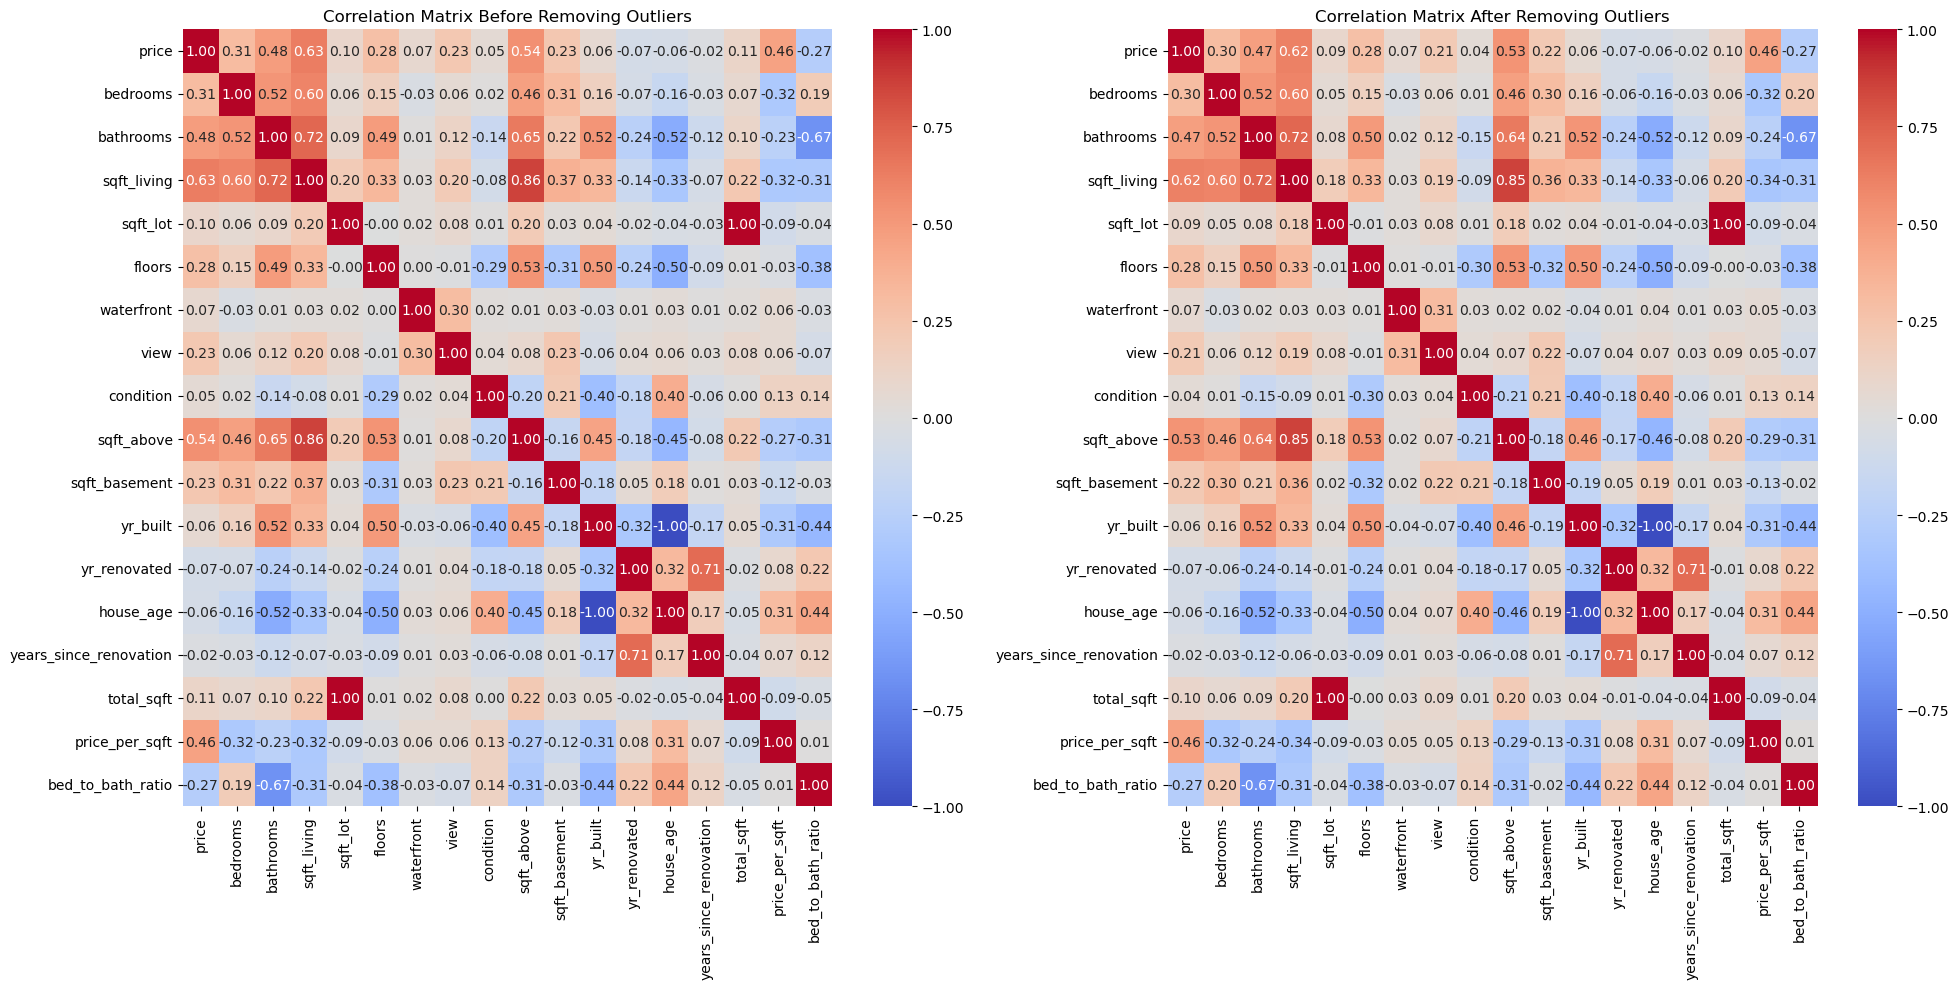

In [20]:
# Update list of numerical columns to include new features
numerical_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                     'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 
                     'yr_built', 'yr_renovated', 'house_age', 'years_since_renovation', 
                     'total_sqft', 'price_per_sqft', 'bed_to_bath_ratio']

# Handling missing values by filling them with the mean for numerical columns
for column in numerical_columns:
    data_fillmean[column] = data_fillmean[column].fillna(data_fillmean[column].mean())

# Removing duplicates
data_fillmean = data_fillmean.drop_duplicates()

# Storing data before removing outliers
data_before_outliers = data_fillmean.copy()

# Identifying and removing outliers in 'price'
q1 = data_fillmean['price'].quantile(0.25)
q3 = data_fillmean['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data_fillmean = data_fillmean[(data_fillmean['price'] >= lower_bound) & (data_fillmean['price'] <= upper_bound)]

# Creating heatmaps for all numerical columns
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.heatmap(data_before_outliers[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Before Removing Outliers')

plt.subplot(1, 2, 2)
sns.heatmap(data_fillmean[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix After Removing Outliers')

plt.tight_layout()
plt.show()

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'sqft_above', 'sqft_basement', 'street', 'city', 'statezip',
       'house_age', 'total_sqft', 'price_per_sqft', 'bed_to_bath_ratio'],
      dtype='object')


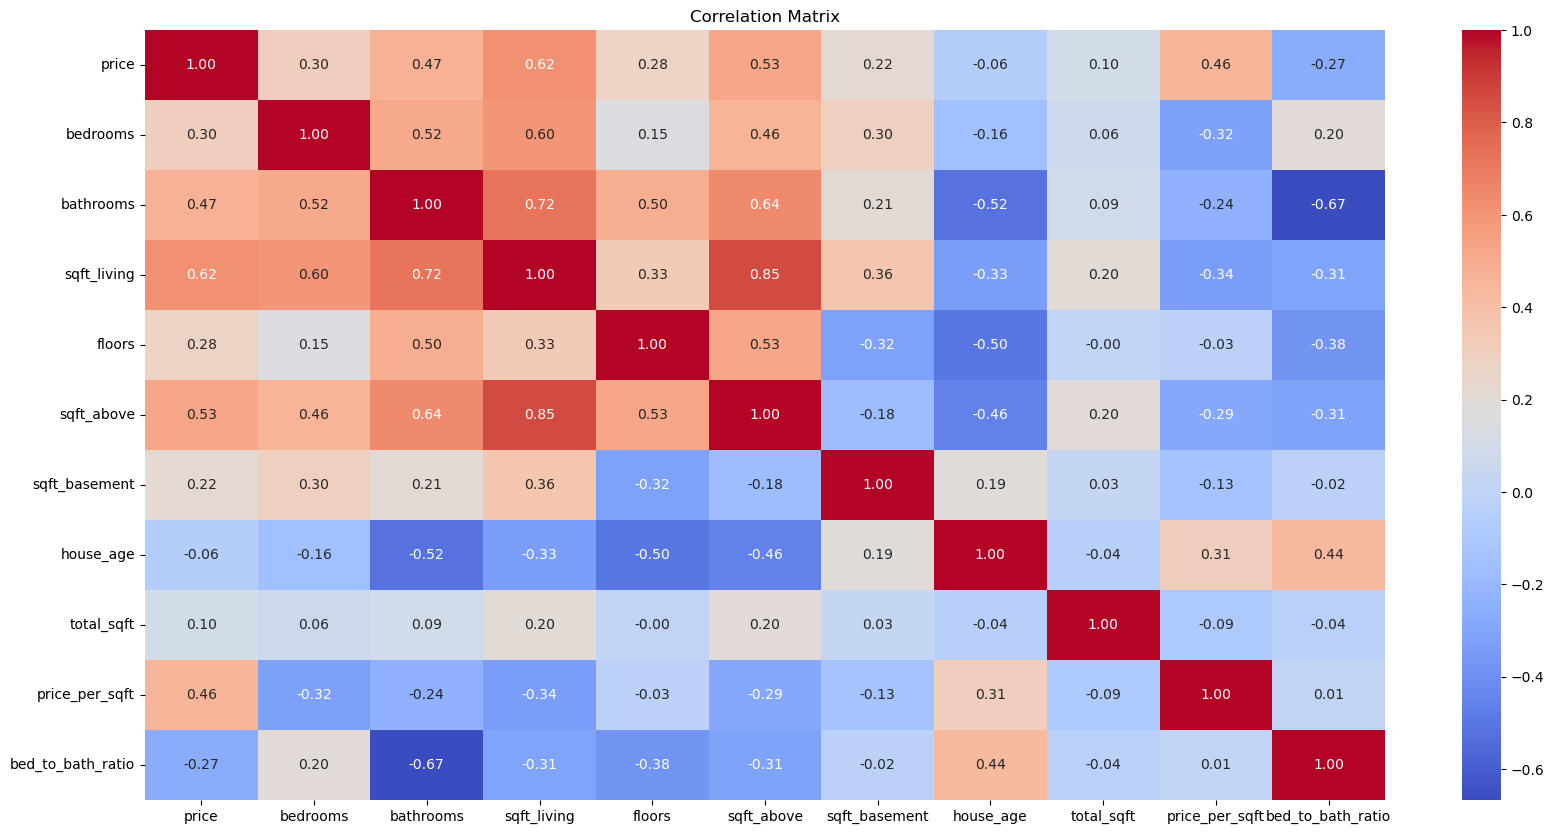

In [21]:
# List of columns to drop based on  analysis (provided in readme.md)
columns_to_drop = [
    'waterfront', 'condition', 'yr_built', 'years_since_renovation', 
    'yr_renovated', 'view', 'sqft_lot', 'country'
]

# Remove the unnecessary columns
data_fillmean = data_fillmean.drop(columns=columns_to_drop, errors='ignore')

# Check the remaining columns to ensure they are dropped
print(data_fillmean.columns)

# Save the cleaned dataset
data_fillmean.to_csv('dataset/cleaned_data.csv', index=False)
numerical_columns = data_fillmean.select_dtypes(include=['number']).columns
data_numeric = data_fillmean[numerical_columns]

# Creating heatmap for correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Most Useful Variables


sqft_living - This variable shows the strongest correlation with price at 0.62. It represents the square footage of the living area, which is a major determinant of housing prices.


bathrooms - Correlation with price is 0.47. The number of bathrooms in a house typically adds value and is a significant factor for potential buyers.


sqft_above - The square footage of the house apart from the basement (correlation with price is 0.53), which indicates that larger living spaces above ground are valued higher.


sqft_basement - While not as strongly correlated as sqft_living (0.22 with price), it still contributes to the overall utility and potential value of the property.


Moderately Useful Variables


bedrooms - Has a correlation of 0.30 with price. While important, bedrooms might not influence the price as much as the overall living space or the number of bathrooms.


floors - The number of floors has a correlation of 0.28 with price, suggesting that multi-story homes can be valued higher but the effect is moderate.


Least Useful Variables


house_age - The correlation with price is very weak (-0.06), indicating that the age of the house might not be a significant predictor of its price in this dataset.


total_sqft - Despite sounding like a critical measure, it shows a very low correlation (0.10) with price, which might be due to redundancy or overlap with other variables like sqft_living and sqft_above.


bed_to_bath_ratio - This variable actually has a negative correlation (-0.27) with price, suggesting that a higher number of bathrooms per bedroom can decrease the price, which can seem counterintuitive and might not be very useful in predicting house prices.


Conclusion
Focus primarily on sqft_living, bathrooms, sqft_above, and potentially sqft_basement for the strongest predictive power. Variables like house age and total_sqft appear less useful based on their low correlation with house price.

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'sqft_above', 'sqft_basement', 'street', 'city', 'statezip',
       'price_per_sqft'],
      dtype='object')


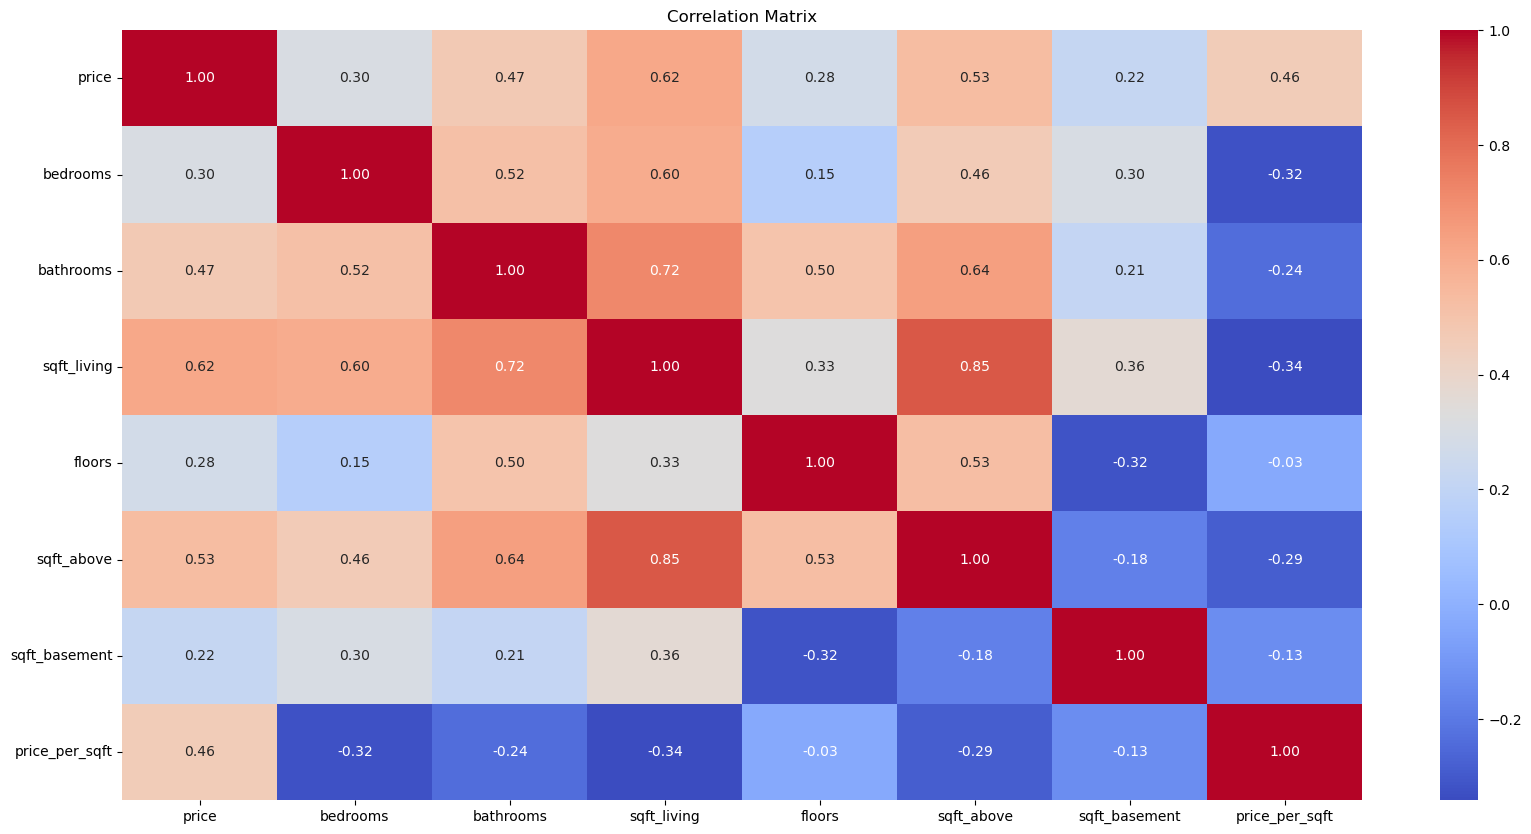

In [22]:
# List of columns to drop based on  analysis (provided in readme.md)
columns_to_drop = [
    'house_age', 'total_sqft', 'bed_to_bath_ratio'
]

# Remove the unnecessary columns
data_fillmean = data_fillmean.drop(columns=columns_to_drop, errors='ignore')

# Check the remaining columns to ensure they are dropped
print(data_fillmean.columns)

# Save the cleaned dataset
data_fillmean.to_csv('dataset/cleaned_data.csv', index=False)
numerical_columns = data_fillmean.select_dtypes(include=['number']).columns
data_numeric = data_fillmean[numerical_columns]

# Creating heatmap for correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()